# Dependencies

In [1]:
import os, warnings, shutil
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tokenizers import ByteLevelBPETokenizer
from tweet_utility_preprocess_roberta_scripts import *
from sklearn.model_selection import StratifiedKFold


SEED = 0
warnings.filterwarnings("ignore")

# Load data

In [2]:
train_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')

# pre-process
train_df.dropna(inplace=True)
train_df = train_df.reset_index()
train_df.drop('index', axis=1, inplace=True)
train_df["text"] = train_df["text"].apply(lambda x: x.strip())
train_df["selected_text"] = train_df["selected_text"].apply(lambda x: x.strip())
train_df["text"] = train_df["text"].apply(lambda x: x.lower())
train_df["selected_text"] = train_df["selected_text"].apply(lambda x: x.lower())

train_df['text_len'] = train_df['text'].apply(lambda x : len(x))
train_df['selected_text_len'] = train_df['selected_text'].apply(lambda x : len(x))
train_df['text_wordCnt'] = train_df['text'].apply(lambda x : len(x.split(' ')))
train_df['selected_text_wordCnt'] = train_df['selected_text'].apply(lambda x : len(x.split(' ')))

sentiment_cols = train_df['sentiment'].unique()

print('Train samples: %s' % len(train_df))
display(train_df.head())

Train samples: 27480


,textID,text,selected_text,sentiment,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,35,35,7,7
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,45,8,10,2
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,5,2
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,5,3
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,74,13,14,3


# Tokenizer

In [3]:
MAX_LEN = 96
base_path = '/kaggle/input/qa-transformers/roberta/'
vocab_path = base_path + 'roberta-base-vocab.json'
merges_path = base_path + 'roberta-base-merges.txt'

tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Tokenizer sanity check

In [4]:
for idx in range(10):
    print('\nRow %d' % idx)
    max_seq_len = 32
    text = train_df['text'].values[idx]
    selected_text = train_df['selected_text'].values[idx]
    question = train_df['sentiment'].values[idx]
    
    _, y = preprocess_roberta(' ' + text, selected_text, ' ' + question, tokenizer, max_seq_len)
    target_start, target_end = y
    
    question_encoded = tokenizer.encode(question).ids
    question_size = len(question_encoded) + 3
    
    decoded_text = decode(target_start.argmax(), target_end.argmax(), text, question_size, tokenizer)
    
    print('text         : "%s"' % text)
    print('selected_text: "%s"' % selected_text)
    print('decoded_text : "%s"' % decoded_text)
    
    assert selected_text == decoded_text


Row 0
text         : "i`d have responded, if i were going"
selected_text: "i`d have responded, if i were going"
decoded_text : "i`d have responded, if i were going"

Row 1
text         : "sooo sad i will miss you here in san diego!!!"
selected_text: "sooo sad"
decoded_text : "sooo sad"

Row 2
text         : "my boss is bullying me..."
selected_text: "bullying me"
decoded_text : "bullying me"

Row 3
text         : "what interview! leave me alone"
selected_text: "leave me alone"
decoded_text : "leave me alone"

Row 4
text         : "sons of ****, why couldn`t they put them on the releases we already bought"
selected_text: "sons of ****,"
decoded_text : "sons of ****,"

Row 5
text         : "http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth"
selected_text: "http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth"
decoded_text : "http://www.dothebouncy.com/smf - some shameless plugging for the best rangers for

## Data generation sanity check

In [5]:
for idx in range(5):
    print('\nRow %d' % idx)
    max_seq_len = 24
    text = train_df['text'].values[idx]
    selected_text = train_df['selected_text'].values[idx]
    question = train_df['sentiment'].values[idx]
    
    x_train, y_train = get_data(train_df[idx:idx+1], tokenizer, max_seq_len, preprocess_fn=preprocess_roberta)
    
    print('text           : "%s"' % text)
    print('input_ids      : "%s"' % x_train[0][0])
    print('attention_mask : "%s"' % x_train[1][0])
    print('selected_text: "%s"' % selected_text)
    print('start        : "%s"' % y_train[0][0])
    print('end          : "%s"' % y_train[1][0])
    
    assert len(x_train) == 2
    assert len(y_train) == 2
#     assert len(x_train[0][0]) == len(x_train[1][0]) == len(x_train[2][0]) == len(y_train[0][0]) == len(y_train[1][0]) == max_seq_len
    assert len(x_train[0][0]) == len(x_train[1][0]) == len(y_train[0][0]) == len(y_train[1][0]) == max_seq_len


Row 0
text           : "i`d have responded, if i were going"
input_ids      : "[    0  7974     2     2   939 12905   417    33  2334     6   114   939
    58   164     2     1     1     1     1     1     1     1     1     1]"
attention_mask : "[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]"
selected_text: "i`d have responded, if i were going"
start        : "[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]"
end          : "[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]"

Row 1
text           : "sooo sad i will miss you here in san diego!!!"
input_ids      : "[    0  2430     2     2    98  3036  5074   939    40  2649    47   259
    11 15610  1597  2977 16506     2     1     1     1     1     1     1]"
attention_mask : "[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]"
selected_text: "sooo sad"
start        : "[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]"
end          : "[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]"

Row 2
text           : "my boss is bullying me..

# 5-Fold split

In [6]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df['sentiment'])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n+1, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % str(fold_n+1))] = 0
    train_df[('fold_%s' % str(fold_n+1))].loc[train_idx] = 'train'
    train_df[('fold_%s' % str(fold_n+1))].loc[val_idx] = 'validation'

Fold: 1, Train size: 21984, Validation size 5496
Fold: 2, Train size: 21984, Validation size 5496
Fold: 3, Train size: 21984, Validation size 5496
Fold: 4, Train size: 21984, Validation size 5496
Fold: 5, Train size: 21984, Validation size 5496


## Sentiment distribution

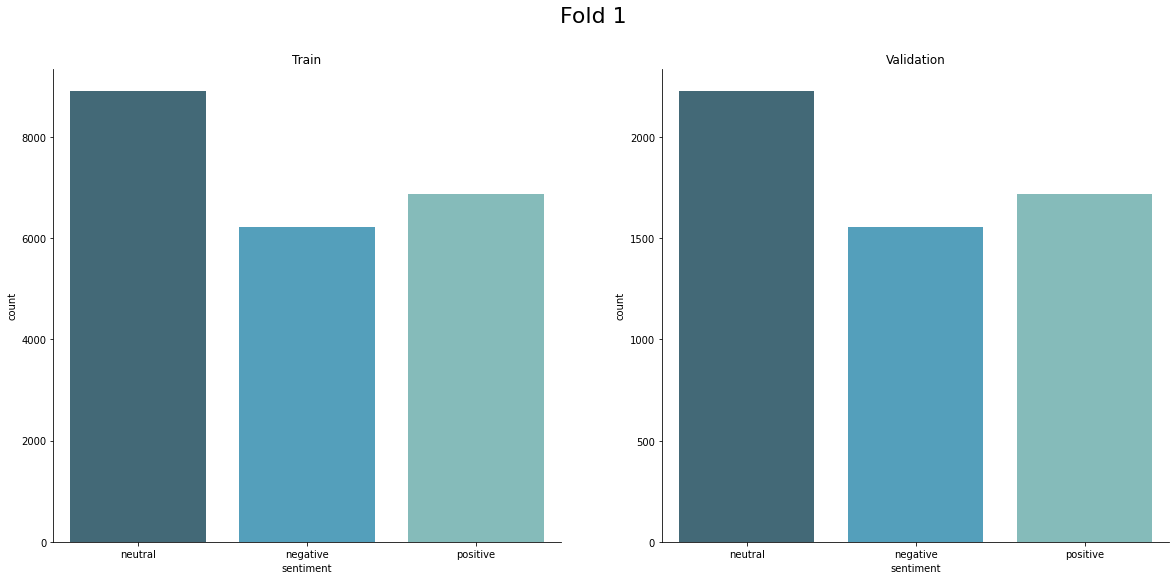

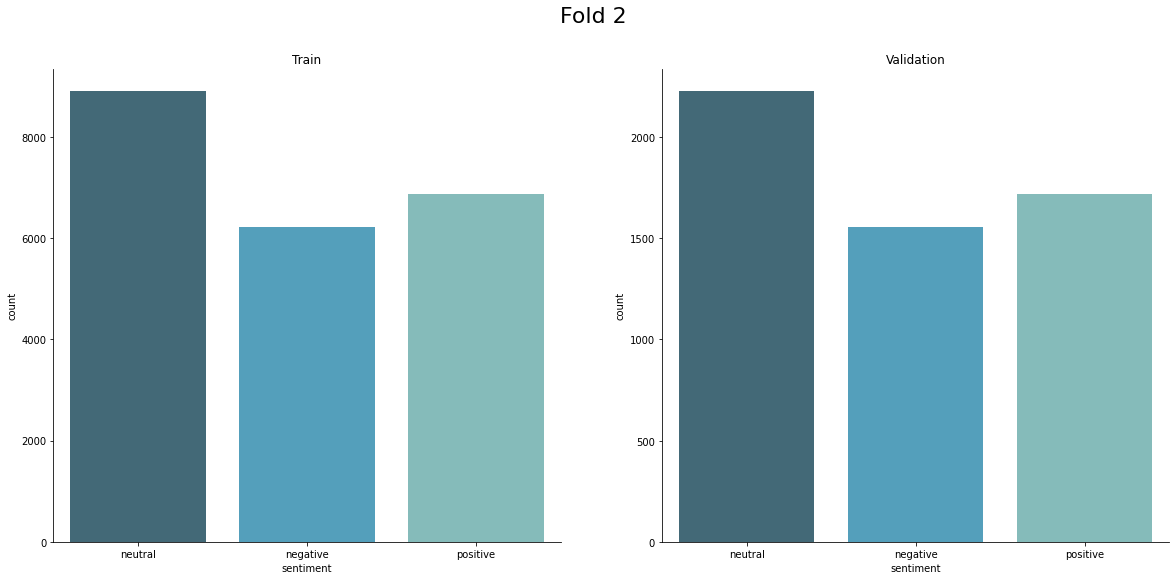

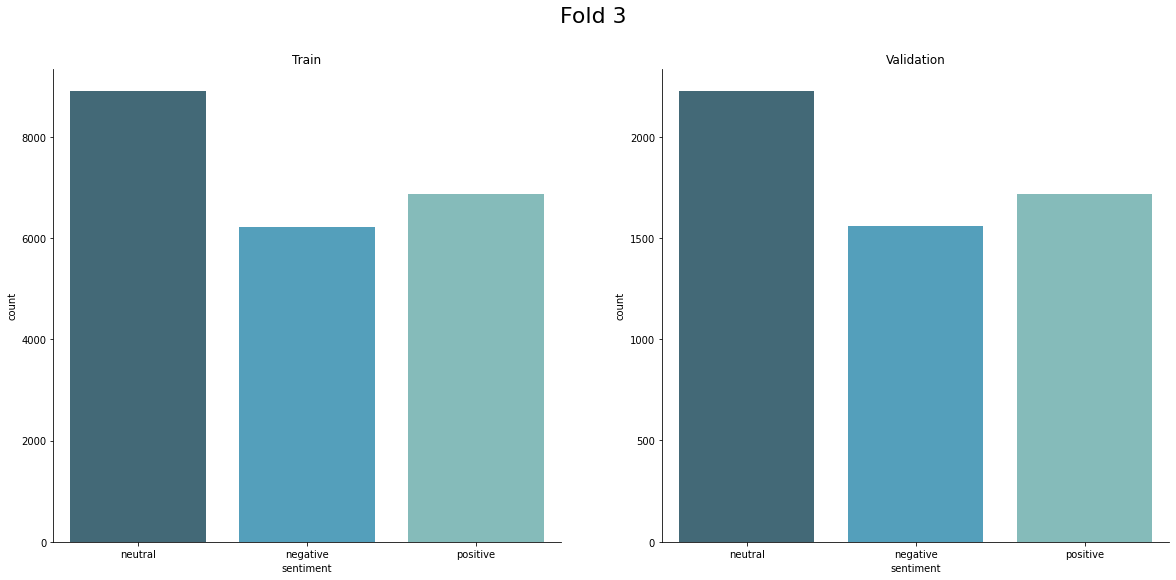

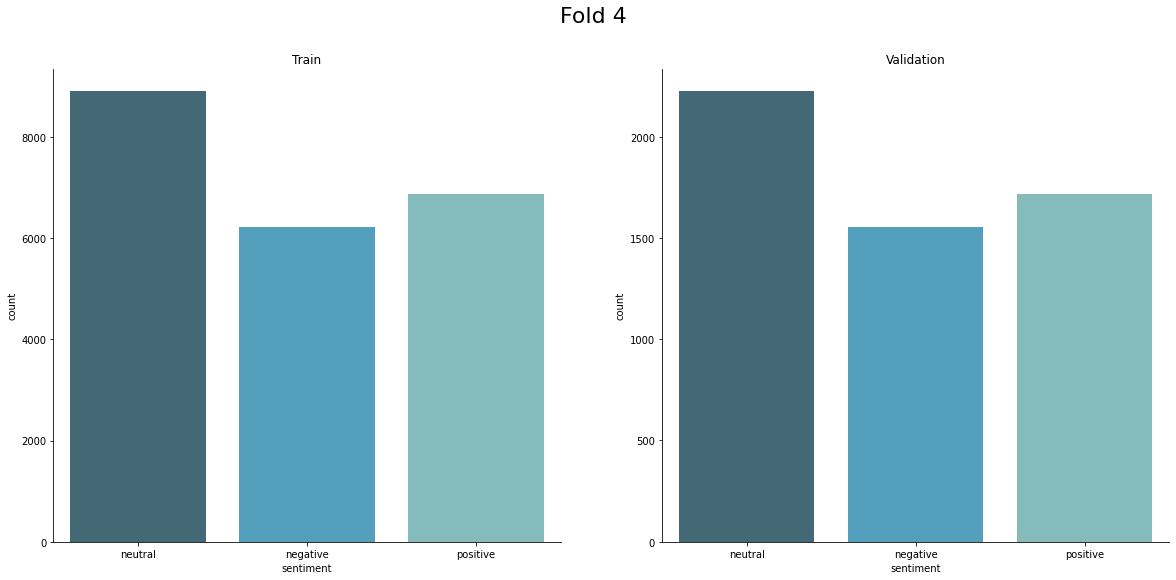

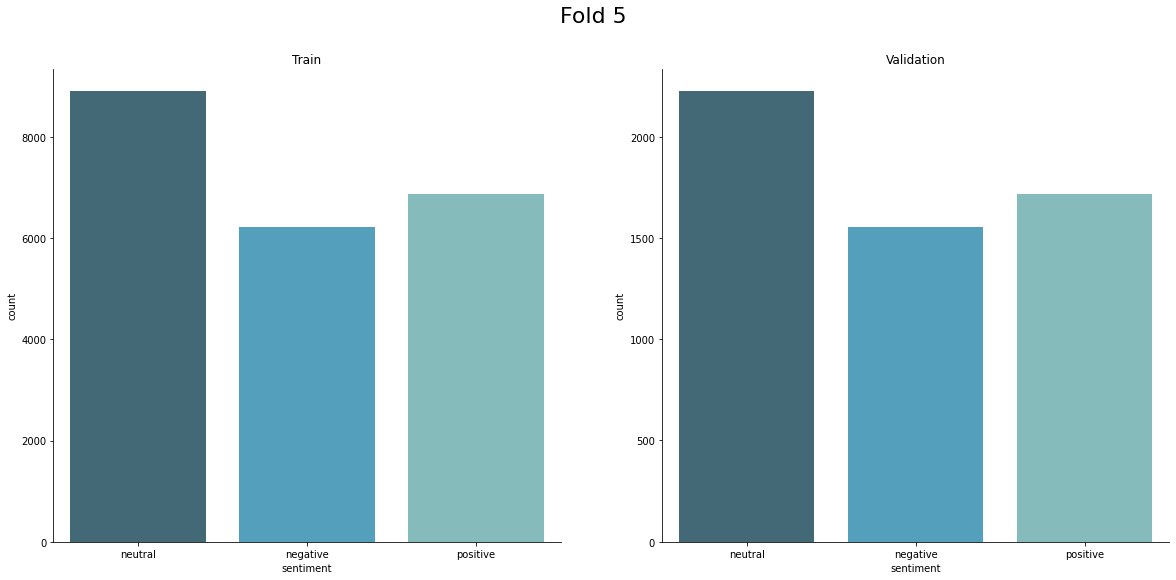

In [7]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.7))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="sentiment", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", order=sentiment_cols, ax=ax1).set_title('Train')
    sns.countplot(x="sentiment", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", order=sentiment_cols, ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

## Word count distribution

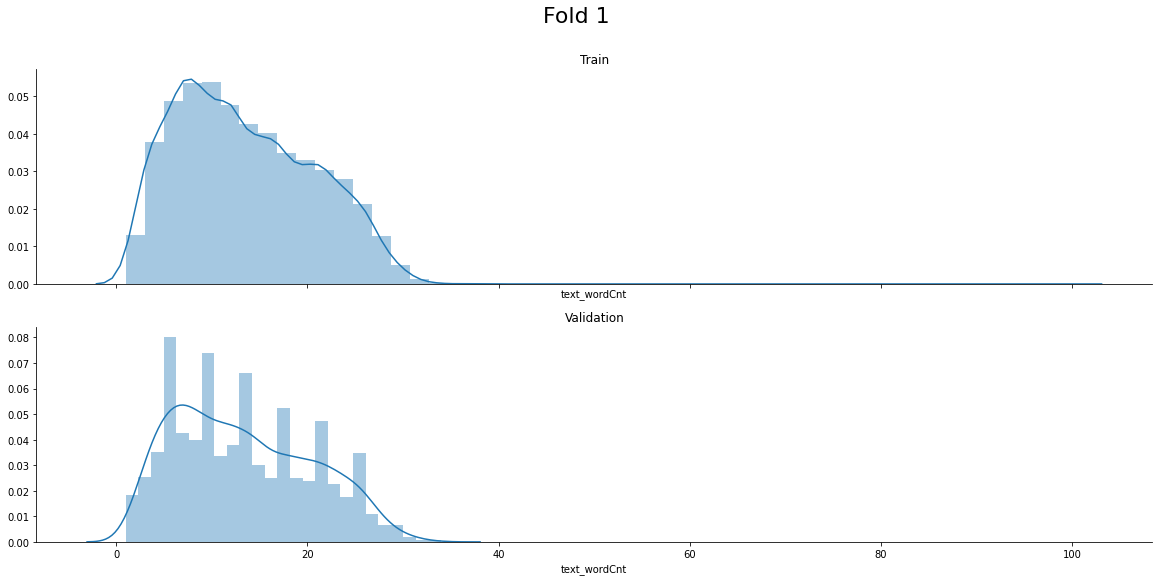

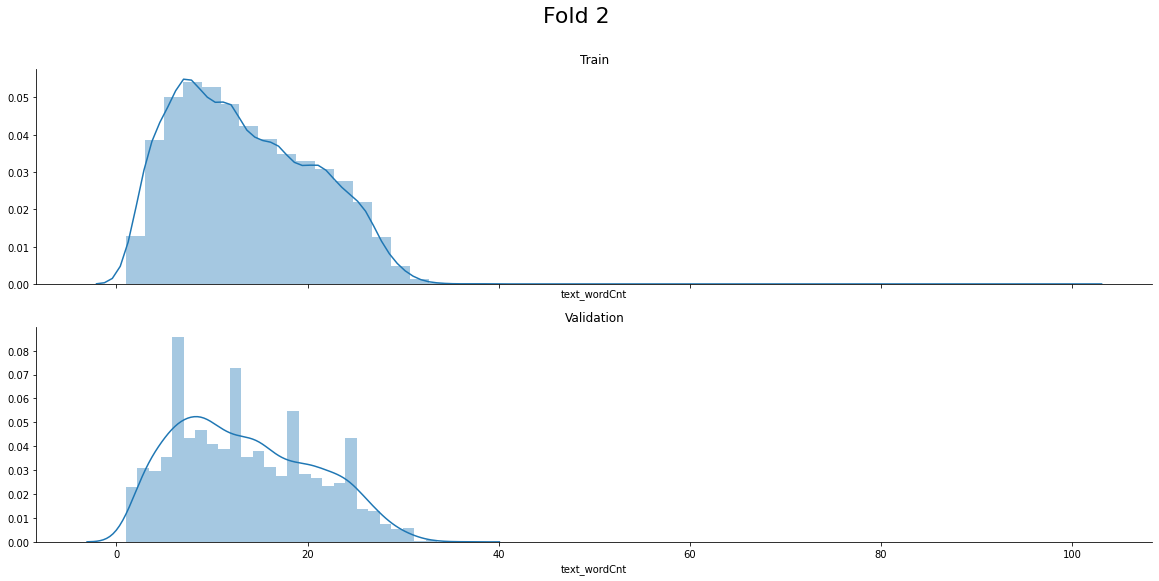

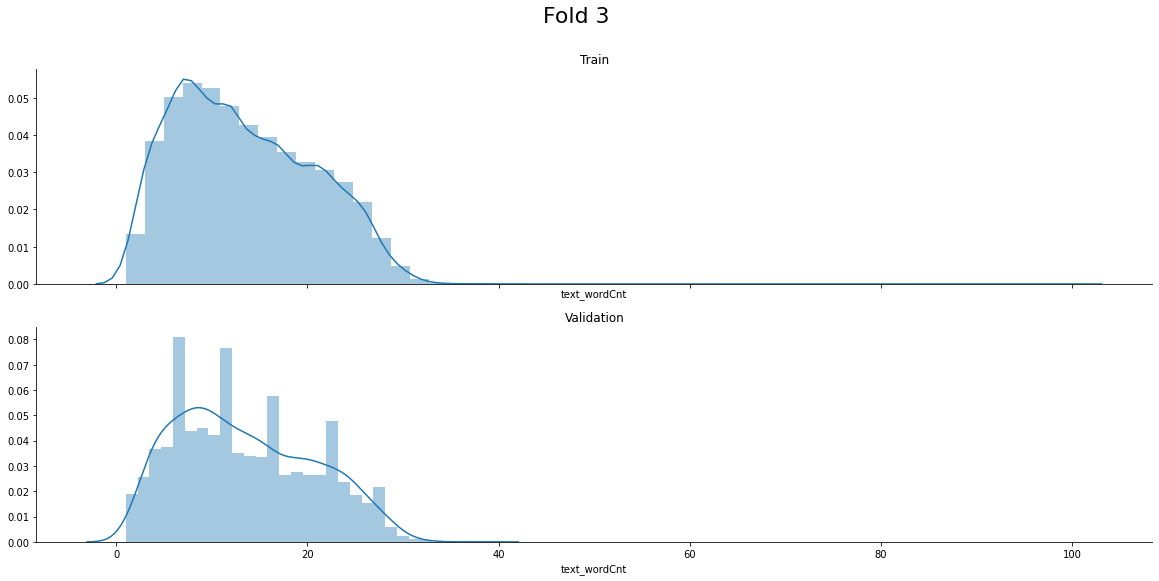

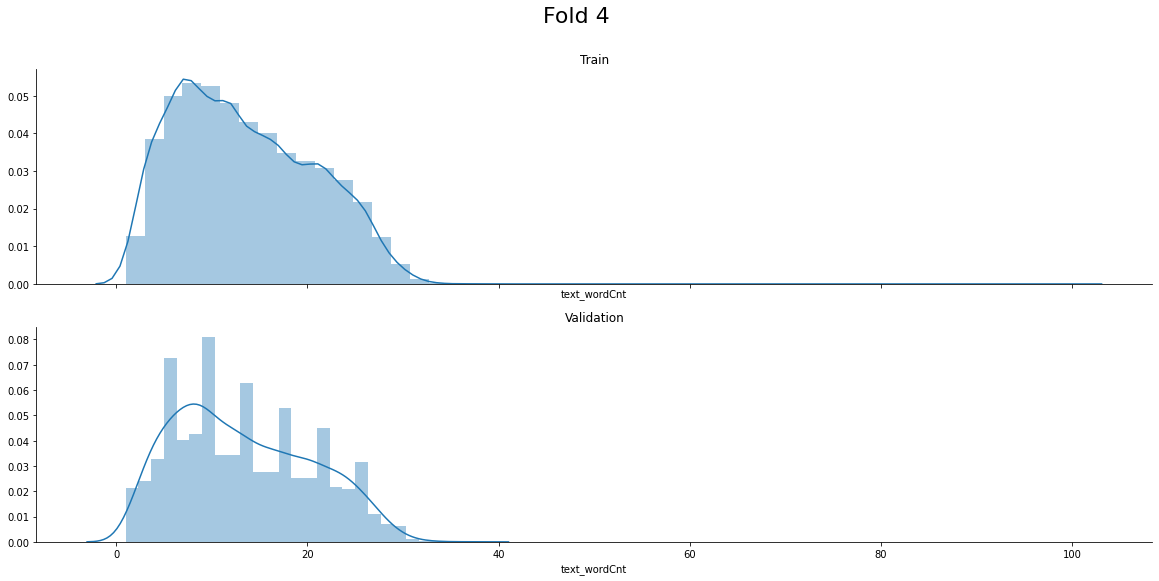

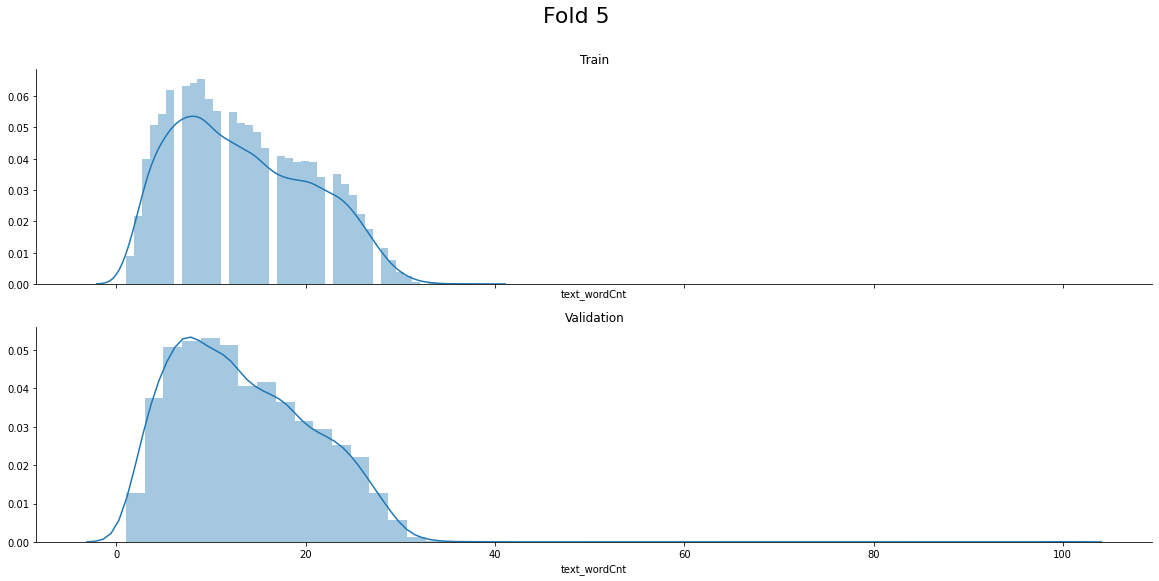

In [8]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
    fig.suptitle('Fold %s' % fold_n, fontsize=22)
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'train']['text_wordCnt'], ax=ax1).set_title("Train")
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'validation']['text_wordCnt'], ax=ax2).set_title("Validation")
    sns.despine()
    plt.show()

## Output 5-fold set

In [9]:
train_df.to_csv('5-fold.csv', index=False)
display(train_df.head())

for fold_n in range(folds.n_splits):
    fold_n += 1
    
    base_path = 'fold_%d/' % fold_n
    # Create dir
    os.makedirs(base_path)
    
    x_train, y_train = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'train'], tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
    x_valid, y_valid = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'validation'], tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)

    np.save(base_path + 'x_train', np.asarray(x_train))
    np.save(base_path + 'y_train', np.asarray(y_train))
    np.save(base_path + 'x_valid', np.asarray(x_valid))
    np.save(base_path + 'y_valid', np.asarray(y_valid))
    
#  Compress logs dir
!tar -cvzf fold_1.tar.gz fold_1
!tar -cvzf fold_2.tar.gz fold_2
!tar -cvzf fold_3.tar.gz fold_3
!tar -cvzf fold_4.tar.gz fold_4
!tar -cvzf fold_5.tar.gz fold_5

# Delete logs dir
shutil.rmtree('fold_1')
shutil.rmtree('fold_2')
shutil.rmtree('fold_3')
shutil.rmtree('fold_4')
shutil.rmtree('fold_5')

,textID,text,selected_text,sentiment,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/y_train.npy
fold_1/x_train.npy
fold_1/y_valid.npy
fold_1/x_valid.npy
fold_2/
fold_2/y_train.npy
fold_2/x_train.npy
fold_2/y_valid.npy
fold_2/x_valid.npy
fold_3/
fold_3/y_train.npy
fold_3/x_train.npy
fold_3/y_valid.npy
fold_3/x_valid.npy
fold_4/
fold_4/y_train.npy
fold_4/x_train.npy
fold_4/y_valid.npy
fold_4/x_valid.npy
fold_5/
fold_5/y_train.npy
fold_5/x_train.npy
fold_5/y_valid.npy
fold_5/x_valid.npy
